In [67]:
import pandas as pd

import os
import random

import matplotlib.pyplot as plt
import numpy as np

import xgboost

from yellowbrick.classifier import ClassificationReport

from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split 

#to save model
import joblib

"""
usage joblib
# save the model: 
joblib.dump(model , "model.pkl")
# load the model:
model = joblib.load("model.pkl")
"""

'\nusage joblib\n# save the model: \njoblib.dump(model , "model.pkl")\n# load the model:\nmodel = joblib.load("model.pkl")\n'

In [ ]:
os.getcwd()

## We want to have a dataframe with:
* X: rows = patients, cols = proteins filled with the protein quantity
* y: rows = patients, col  = health condition (healthy, cancer A, cancer B)

In [43]:
path = r"rawData\tidy.csv"
tidy = pd.read_csv(path, sep=",")

tidy.head()

tidySub = tidy[["R.FileName", "uniprot", "meanAbu", "Group"]]

tidySub.head()

,R.FileName,uniprot,meanAbu,Group
0,G_D200423_MDIA_P671_S46_R01,A0A075B6H7,5657.235840,Healthy
1,G_D200423_MDIA_P671_S46_R01,A0A075B6I0,5067.330078,Healthy
2,G_D200423_MDIA_P671_S46_R01,A0A075B6I9,5604.411621,Healthy
3,G_D200423_MDIA_P671_S46_R01,A0A075B6K4,10224.492188,Healthy
4,G_D200423_MDIA_P671_S46_R01,A0A075B6K5,6343.487793,Healthy


### To feed the data inot a model we need to reshape

In [44]:
#reshape data
#X data
tidyReshaped = tidySub.pivot(index = "R.FileName", columns = "uniprot", values = "meanAbu")
tidyReshaped.head()
#y condition
Group =  tidySub.drop(["uniprot", "meanAbu"], axis=1)
Group = Group.drop_duplicates().reset_index(drop=True)
Group.head()

#we merge to ensure that the y rows fit the corresponding x rows
data = pd.merge(tidyReshaped, Group, how="left", on="R.FileName")

#to make df purely numerical
data = data.set_index("R.FileName")

X = data.iloc[:, :-1]
y = data.iloc[:,-1]

### Now that the data is prepared we continue with the following steps:
* Create pipeline for imputing, scaling !! **Scaling is not needed for Random Forest**
* (https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)
* Creation of training, validation and test sets
* Feature Selection, Engineering
* Model Selection

In [45]:
#Make pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

dataPrepPipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ]) 

#X is already purely numerical
X = dataPrepPipe.fit_transform(X)

In [46]:
# Encode target labels
from sklearn import preprocessing

labEnc = preprocessing.LabelEncoder() 

# apply label encoding
y = labEnc.fit_transform(y) 
print(y)

[0 3 2 2 1 2 1 0 0 0 1 2 3 0 1 0 3 0 2 0 1 3 0 0 0 3 0 2 0 0 1 0 1 3]


In [47]:
# Save X and y for next session

joblib.dump(y, "Models/y.pkl")
joblib.dump(X, "Models/X.pkl")


['Models/X.pkl']

In [48]:
# load saved X and y 

y = joblib.load("Models/y.pkl")
X = joblib.load("Models/X.pkl")


(34, 381)

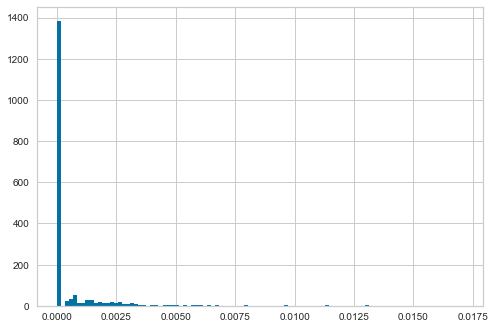

In [49]:
# Feature Selection

"""
Can be used in pipeline
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #checkout description https://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection

#create Random Forest classifier with default hyperparameters
raFo = RandomForestClassifier()
raFo = raFo.fit(X, y)

#checkout importance in a histogram
plt.hist(raFo.feature_importances_, bins=100)

#get the reduced X
model = SelectFromModel(estimator = raFo, prefit=True)
X_new = model.transform(X)
X_new.shape   

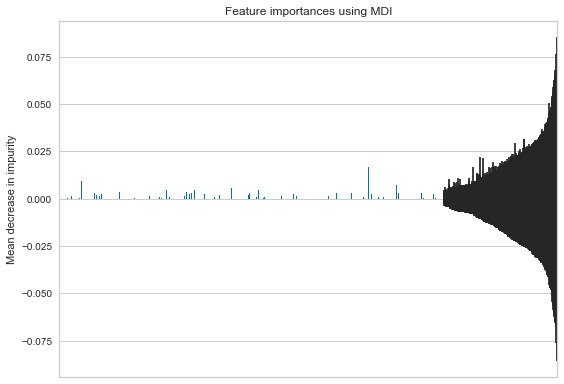

' plt.rcParams["figure.figsize"] = (10,5)\nplt.bar(raFo.feature_names, raFo.feature_importances_)\nplt.xlabel(\'Feature Labels\')\nplt.ylabel(\'Feature Importances\')\nplt.title(\'Comparison of different Feature Importances\'); '

In [86]:
# Visualize feature importance

importances = raFo.feature_importances_

std = np.std([tree.feature_importances_ for tree in raFo.estimators_], axis=0)
std.sort()

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.get_xaxis().set_visible(False)
fig.tight_layout()
plt.show()

""" plt.rcParams["figure.figsize"] = (10,5)
plt.bar(raFo.feature_names, raFo.feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances'); """

## Time to train the model


In [53]:
# import already trained model

clf_RF = joblib.load("Models/clf_RF_X_new.pkl")
clf_XGRF = joblib.load("Models/clf_XGRF_X_new.pkl")


### Random Forest

In [75]:
#split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=3)

clf_RF = RandomForestClassifier(random_state=1)
clf_RF.fit(X_train ,y_train)
y_RFpred = clf_RF.predict(X_test)




# Model Accuracy, how often is the classifier correct?
print("Accuracy Random Forest:",metrics.accuracy_score(y_test , y_RFpred))
print(classification_report(y_test, y_RFpred))


Accuracy Random Forest: 0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0

    accuracy                           0.86         7
   macro avg       0.75      0.62      0.67         7
weighted avg       1.00      0.86      0.90         7



C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XGBoost Random Forest

In [76]:
params = dict(tree_method="exact", 
                num_class=7,
                learning_rate=0.1,
                num_iterations=1000,
                max_depth=10,
                feature_fraction=0.7, 
                scale_pos_weight=1.5,
                boosting='gbdt',
                metric='multiclass',
                eval_metric='mlogloss',
                use_label_encoder =False)

clf_XGRF = xgboost.XGBClassifier(random_state=1, **params)

clf_XGRF.fit(X_train ,y_train)
y_XGRFpred = clf_XGRF.predict(X_test)

print("Accuracy XGBoost Random Forest:",metrics.accuracy_score(y_test , y_XGRFpred))
print(classification_report(y_test, y_XGRFpred))

[11:58:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boosting", "feature_fraction", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Accuracy XGBoost Random Forest: 0.8571428571428571
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         0

    accuracy                           0.86         7
   macro avg       0.75      0.62      0.67         7
weighted avg       1.00      0.86      0.90         7



C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kevin\anaconda3\envs\python38_r411\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
#save the model
joblib.dump(clf_RF, "Models/clf_RF_X_new.pkl")
joblib.dump(clf_XGRF, "Models/clf_XGRF_X_new.pkl")

['Models/clf_XGRF_X_new.pkl']

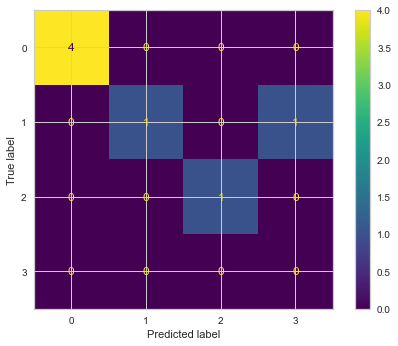

In [63]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_RFpred, labels=clf_RF.classes_) # calculate value
disp = ConfusionMatrixDisplay(confusion_matrix=cm,              # display
                              display_labels=clf_RF.classes_)
disp.plot(); 



## Compare uncertainty of Data and Model

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_RF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()

modAcuRF = []
for rs in range(1,6):
    model = RandomForestClassifier(random_state=random.randrange(rs))
    model.fit(X_train, y_train)
    modAcuRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

Uncertainty in the data: 0.152
Uncertainty in the model: 0.000
The model performance is 0.710 ± 0.152 ± 0.000


In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_XGRF, X_new, y, cv=5, scoring='accuracy')
Udata = scores.std()


modAcuXGRF = []
for rs in range(1,6):
    model = xgboost.XGBClassifier(random_state=random.randrange(rs), **params)
    model.fit(X_train, y_train)
    modAcuXGRF += [accuracy_score(y_test, model.predict(X_test))]

Umodel = np.std(modAcuXGRF)

print("Uncertainty in the data: %.3f" % Udata)
print("Uncertainty in the model: %.3f" % Umodel)
print("The model performance is %.3f ± %.3f ± %.3f" % (scores.mean(),Udata,Umodel))

[11:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boosting", "feature_fraction", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "boosting", "feature_fraction", "metric", "num_iterations", "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:57:11] WARNING: C:/Users/A